In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
sys.path.append('/content/drive/MyDrive/gcolab/bacteria_segmentation')
os.chdir('/content/drive/MyDrive/gcolab/bacteria_segmentation')

In [3]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 952kB 24.9MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Imports

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch.transforms import ToTensor, ToTensorV2

import cv2

from sklearn.model_selection import train_test_split

import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm
import copy

## Dataset
_LABELS_ — named masks labels as strings  
_LABELS_FREQ_ — number of pixels in whole dataset per each label  
_LABELS_MAPPING_ — mapping from labels to mask values

In [5]:
class BacteriaDataset(Dataset):

  LABELS = ['_background', '_epidermidis', '_pneumoniae', '_aureus', '_moraxella', '_kefir', '_cloacae']
  LABELS_FREQ = [83935852, 86426, 74084, 31883, 248657, 879189, 268389]
  LABELS_MAPPING = dict(zip(LABELS, list(range(len(LABELS)))))

  def __init__(self, df_data, images_path, masks_path_postfix, transform=None, transform_image=None, transform_mask=None):
    self.df_data = copy.deepcopy(df_data)
    self.images_path = images_path
    self.masks_path_postfix = masks_path_postfix

    self.transform = transform
    self.transform_image = transform_image
    self.transform_mask = transform_mask

  def __len__(self):
    return self.df_data.shape[0]

  def __getitem__(self, idx):
    filename = format(self.df_data.iloc[idx]['filename'], '03d')
    label = self.df_data.iloc[idx]['labels']

    image = cv2.imread(os.path.join(self.images_path, f'{filename}.png')) # load image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # to optimize process we can load only mask with label from df_data (all others are zero - background)
    mask = cv2.imread(os.path.join(self.images_path, f'{filename}{self.masks_path_postfix}/', f'{filename}{label}.png'), cv2.IMREAD_UNCHANGED) # load labeled mask
    
    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      image, mask = transformed['image'], transformed['mask']

    mask[mask != 0] = BacteriaDataset.LABELS_MAPPING[label]

    if self.transform_image is not None:
      image = self.transform_image(image=image)['image']

    if self.transform_mask is not None:
      mask = self.transform_mask(mask).long()

    return image, mask

## Train and val data
use _train_test_split_ to split dataset on train and val sets with approximately same proportion of labels

In [6]:
df_data = pd.read_csv('bacteria_segmentation_eda.csv')
df_train, df_val = train_test_split(df_data, stratify=df_data['labels'])

check the proportion of labels in train and val sets

In [7]:
{
    'data': df_data['labels'].value_counts(normalize=True),
    'train': df_train['labels'].value_counts(normalize=True),
    'val': df_val['labels'].value_counts(normalize=True),
}

{'data': _cloacae        0.356322
 _kefir          0.268199
 _moraxella      0.149425
 _epidermidis    0.095785
 _aureus         0.076628
 _pneumoniae     0.053640
 Name: labels, dtype: float64, 'train': _cloacae        0.358974
 _kefir          0.266667
 _moraxella      0.148718
 _epidermidis    0.097436
 _aureus         0.076923
 _pneumoniae     0.051282
 Name: labels, dtype: float64, 'val': _cloacae        0.348485
 _kefir          0.272727
 _moraxella      0.151515
 _epidermidis    0.090909
 _aureus         0.075758
 _pneumoniae     0.060606
 Name: labels, dtype: float64}

### PyTorch datasets
- resizing image to 256x256
- apply some augmentation on train images

In [8]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90()
    ]
)
val_transform = A.Compose(
    [
        A.Resize(256, 256)
    ]
)

transform_image = A.Compose(
    [
        ToTensor(sigmoid=False)
    ]
)
transform_mask = torch.from_numpy

train_dataset = BacteriaDataset(
    df_train, 'data//train', '_masks', 
    transform=train_transform,
    transform_image=transform_image,
    transform_mask=transform_mask
)
val_dataset = BacteriaDataset(
    df_val, 'data//train', '_masks',
    transform=val_transform,
    transform_image=transform_image,
    transform_mask=transform_mask
)

### MetricMonitor
class used for collecting information about metrics during training/evaluation during epoch

In [9]:
class MetricMonitor:
    def __init__(self, float_precision=4):
      self.float_precision = float_precision
      self.reset()

    def reset(self):
      self.metrics = defaultdict(lambda: {'val': 0, 'count': 0, 'avg': 0})

    def update(self, metric_name, val):
      metric = self.metrics[metric_name]

      metric['val'] += val
      metric['count'] += 1
      metric['avg'] = metric['val'] / metric['count']

    def __str__(self):
      return ' | '.join(
          [
              f'{metric_name}: {format(metric["avg"], f".{self.float_precision}f")}'
              for (metric_name, metric) in self.metrics.items()
          ]
      )

#### ModelTrainAndVal
class used for training given model

_model_ — model to be trained   
_labels_weights_ — weights of each label (to handle class imbalance)   
_params_ — additional parameters like batch size or device  
_train_metrics_ — metrics on each epoch during training  
_val_metrics_ — metrics on each epoch during valudations

during training, if loss on validation is less than _SAVE_THRESHOLD_, model will be saved

In [10]:
class ModelTrainAndVal:
  
  PATH_MODELS_SAVES = 'models/'
  LIMIT_SAVED = 10
  SAVE_THRESHOLD = 0.25

  def __init__(self, model, params, train_dataset, val_dataset, model_name):
    self.params = params

    self.model = model.to(self.params['device'])

    self.labels_weights = np.sum(BacteriaDataset.LABELS_FREQ) / torch.FloatTensor(BacteriaDataset.LABELS_FREQ)

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    self.model_name = model_name
    self.train_metrics = []
    self.val_metrics = []

  def train_epoch(self, train_loader, epoch, metric_monitor, criterion, optimizer):
    metric_monitor.reset()
    self.model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(self.params['device'], non_blocking=True)
        target = target.to(self.params['device'], non_blocking=True)

        output = self.model(images)
        loss = criterion(output, target)
        metric_monitor.update('Loss', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        stream.set_description(
            f'Epoch: {epoch}. Train.    {metric_monitor}'
        )

  def validate_epoch(self, val_loader, epoch, metric_monitor, criterion):
    metric_monitor.reset()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
      for i, (images, target) in enumerate(stream, start=1):
        images = images.to(self.params['device'], non_blocking=True)
        target = target.to(self.params['device'], non_blocking=True)
            
        output = self.model(images)
        loss = criterion(output, target)
        metric_monitor.update('Loss', loss.item())
            
        stream.set_description(
            f'Epoch: {epoch}. Validate. {metric_monitor}'
        )   

  def train(self, epoch_num):
    train_loader = DataLoader(
        self.train_dataset,
        batch_size=self.params['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        self.val_dataset,
        batch_size=self.params['batch_size'],
        pin_memory=True
    )

    criterion = nn.CrossEntropyLoss(weight=self.labels_weights).to(self.params['device'])
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['learning_rate'])

    saved_num = 0
    for epoch in range(1, epoch_num+1):
      train_metric_monitor = MetricMonitor()
      self.train_epoch(train_loader, epoch, train_metric_monitor, criterion, optimizer)
      self.train_metrics.append(train_metric_monitor.metrics)
        
      val_metric_monitor = MetricMonitor()
      self.validate_epoch(val_loader, epoch, val_metric_monitor, criterion)
      self.val_metrics.append(val_metric_monitor.metrics)

      if val_metric_monitor.metrics['Loss']['avg'] <= self.SAVE_THRESHOLD and saved_num <= self.LIMIT_SAVED:
        saved_num += 1
        torch.save(
            model.state_dict(),
            f'{self.PATH_MODELS_SAVES}{self.model_name}-e{epoch}' +
            f'-v_loss{val_metric_monitor.metrics["Loss"]["avg"]}' + 
            f'-t_loss{train_metric_monitor.metrics["Loss"]["avg"]}'
        )

    return model

### U-net model and its parts

In [11]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()

    mid_channels = out_channels if mid_channels is None else mid_channels

    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)


class ContractBlock(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()

    self.contract_path = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels, mid_channels)
    )

  def forward(self, x):
    return self.contract_path(x)


class ExpansiveBlock(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()

    self.upsample = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.double_conv = DoubleConv(in_channels, out_channels, mid_channels)

  def forward(self, x_to_upsample, x_residual):
    x_upsampled = self.upsample(x_to_upsample)
    x_concat = torch.cat([x_residual, x_upsampled], dim=1)

    return self.double_conv(x_concat)


class Unet(nn.Module):
  def __init__(self, in_channels, n_classes):
    super().__init__()

    self.input_conv = DoubleConv(in_channels, 64)
    self.contract1 = ContractBlock(64, 128)
    self.contract2 = ContractBlock(128, 256)
    self.contract3 = ContractBlock(256, 512)

    # dropout
    self.contract4 = ContractBlock(512, 1024)

    # dropout
    self.expansive3 = ExpansiveBlock(1024, 512)
    # dropout
    self.expansive2 = ExpansiveBlock(512, 256)
    # dropout
    self.expansive1 = ExpansiveBlock(256, 128)
    # dropout
    self.expansive0 = ExpansiveBlock(128, 64)

    #dropout
    self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    self.dropout = nn.Dropout2d(0.3)

  def forward(self, x):
    x0 = self.input_conv(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)

    x = self.dropout(x3)
    x = self.contract4(x)

    x = self.dropout(x)
    x = self.expansive3(x, x3)

    x = self.dropout(x)
    x = self.expansive2(x, x2)

    x = self.dropout(x)
    x = self.expansive1(x, x1)

    x = self.dropout(x)
    x = self.expansive0(x, x0)

    x = self.dropout(x)
    x = self.out_conv(x)

    return x

Create model and define params

In [12]:
model = Unet(3, len(BacteriaDataset.LABELS))

In [13]:
params = {
    'learning_rate': 3.e-4,
    'batch_size': 16,
    'device': 'cuda'
}
model_train_and_val = ModelTrainAndVal(model, params, train_dataset, val_dataset, 'unet')

Train model

In [14]:
model = model_train_and_val.train(150)

Epoch: 150. Validate. Loss: 0.6945: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


### Visualize predictions of model
currently sofrmax probability threshold is same for all masks: 0.5

In [27]:
def visualize_predictions(model, num_images):
  model.eval()
  with torch.no_grad():
    pred_transform = A.Compose([A.Resize(256, 256)]) 
    transform_image = A.Compose([ToTensor(sigmoid=False)])
    transform_mask = torch.from_numpy

    pred_dataset = BacteriaDataset(
        df_val, 'data//train', '_masks',
        transform=pred_transform,
        transform_image=transform_image,
        transform_mask=transform_mask
    )
    pred_loader = DataLoader(
        pred_dataset,
        batch_size=num_images,
        pin_memory=True
    )

    image_batch, mask_batch = next(iter(pred_loader))
    image_batch = image_batch.to('cuda')
    mask_pred_batch = nn.Softmax2d()(model(image_batch))
    mask_pred_batch = ((mask_pred_batch >= 0.5).float() * 1).cpu().numpy()

    figure, ax = plt.subplots(nrows=2*num_images, ncols=1+len(BacteriaDataset.LABELS), figsize=(80, 5*num_images))
    for i in range(0, 2*num_images, 2):
      image, mask = image_batch[i//2], mask_batch[i//2]
      image_draw = image.cpu().permute(1, 2, 0).numpy()

      ax[i, 0].imshow(image_draw)
      ax[i, 0].set_title(f'ground truth on image')
      ax[i, 0].set_axis_off()

      ax[i+1, 0].imshow(image_draw)
      ax[i+1, 0].set_title(f'predictions on image')
      ax[i+1, 0].set_axis_off()

      for j, label in enumerate(BacteriaDataset.LABELS):
        ax[i, 1+j].imshow(mask == BacteriaDataset.LABELS_MAPPING[label])
        ax[i, 1+j].set_title(f'{label} ground truth')
        ax[i, 1+j].set_axis_off() 

        ax[i+1, 1+j].imshow(mask_pred_batch[i//2][j])
        ax[i+1, 1+j].set_title(f'{label} mask predicted')
        ax[i+1, 1+j].set_axis_off() 

    plt.tight_layout()
    plt.show()

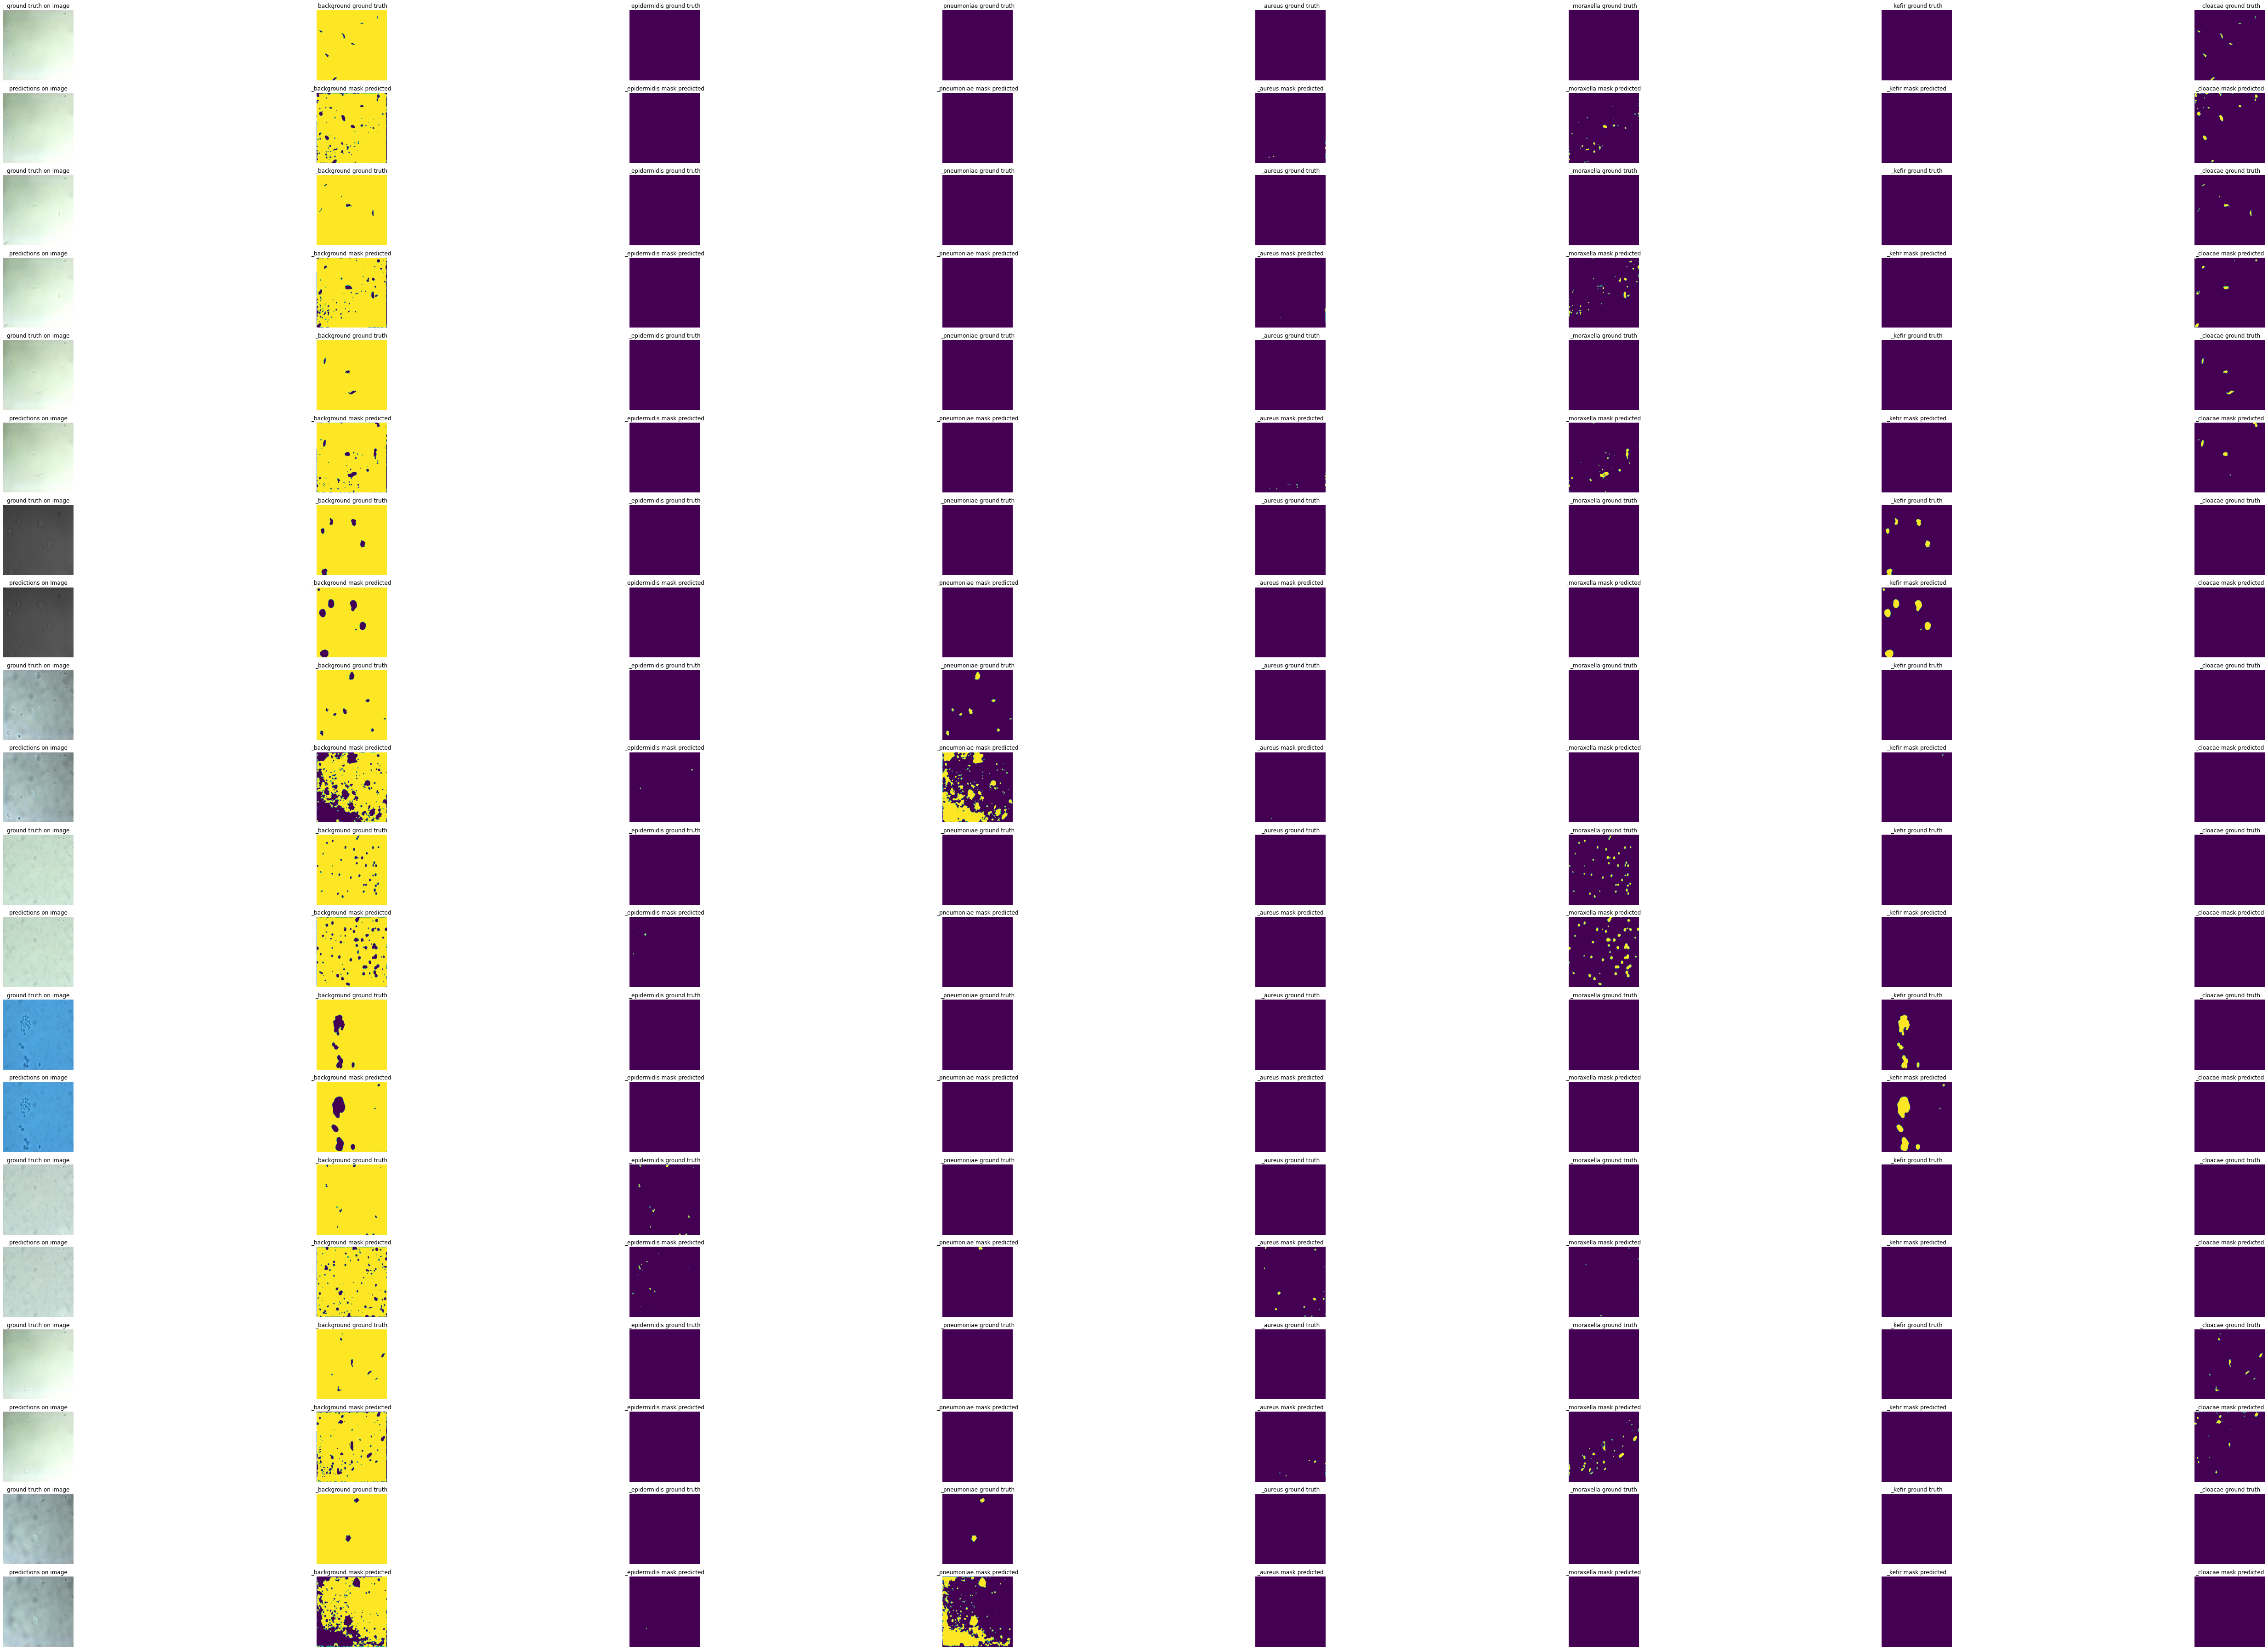

In [28]:
visualize_predictions(model, 10)

### Plot losses

In [17]:
def plot_losses(model_train_and_val, path):
  loss_train = [item['Loss']['avg'] for item in model_train_and_val.train_metrics]
  loss_val = [item['Loss']['avg'] for item in model_train_and_val.val_metrics]

  plt.figure(figsize=(16, 9))
  plt.plot(loss_train, label = 'train')
  plt.plot(loss_val, label='valid')

  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()

  plt.show()
  plt.savefig(path)

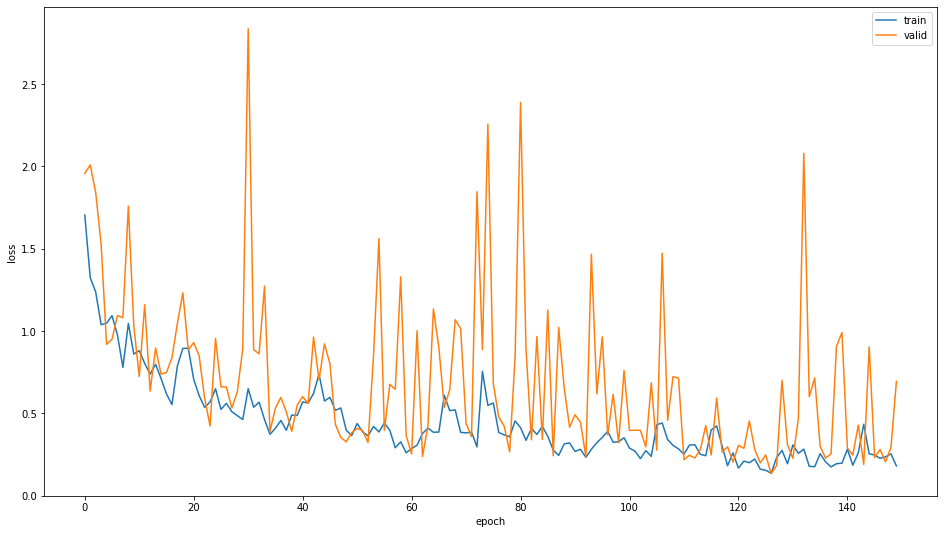

<Figure size 432x288 with 0 Axes>

In [18]:
plot_losses(model_train_and_val, 'loss_unet')

### Resume:
As can be seen from plots of losses above, loss both on validation and train set is "unstable". During training, i observed the fact that loss is rapidly increasing on some specific batches, maybe the problem is related to class imbalance in dataset. 

Plans: 
- use undersamling to solve the imbalance problem of images with different classes
- pick different predictions probability thresholds after softmax
- maybe use another architecture like Y-net: split problem on classification and segmentation